In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [65]:
train_df = pd.read_csv('train.csv',encoding='utf-8').fillna("")
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [66]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(train_df['question1']) + list(train_df['question2'])

tok = CountVectorizer(max_features=2048)
tok.fit(questions)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=2048, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [67]:
counts1 = tok.transform(train_df['question1']).astype(bool)
counts2 = tok.transform(train_df['question2']).astype(bool)

In [73]:
#use these counts to engineer features
xor = counts1 != counts2
both = (counts1+counts2)==2

from scipy.sparse import vstack, hstack

X = hstack([xor,both])
X.shape, train_df.shape

((404290, 4096), (404290, 7))

In [74]:
#add in overlap ratio for words not in the vocabulary

def overlap_ratio(q1,q2):
    
    q1 = [word for word in word_tokenize(q1.lower()) if word not in tok.vocabulary_]
    q2 = [word for word in word_tokenize(q2.lower()) if word not in tok.vocabulary_]
    
    overlap = len(set(q1).intersection(set(q2)))
    union = len(set(q1).union(set(q2)))
    
    return float(overlap)/max(union,1)

train_df['oov_overlap_ratio'] = train_df.apply(lambda x: overlap_ratio(x['question1'],x['question2']),axis=1)



In [75]:
import scipy.sparse

overlap = np.array(train_df['oov_overlap_ratio'])
overlap = scipy.sparse.coo_matrix(overlap)
X=hstack([X,overlap.T])

In [76]:
overlap

<1x404290 sparse matrix of type '<type 'numpy.float64'>'
	with 403835 stored elements in COOrdinate format>

In [77]:
X.shape

(404290, 4097)

In [61]:
#make a quick 'model' using just the unigram ratio

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import SelectKBest

clf = LogisticRegression()
#clf = BernoulliNB(alpha=10)
y = train_df['is_duplicate']

reducer = SelectKBest(k='all')

X_train, X_test, y_train, y_test = train_test_split(X,y)

reducer.fit(X_train,y_train)

X_tr_redc = reducer.transform(X_train)
X_test_redc = reducer.transform(X_test)

clf.fit(X_tr_redc,y_train)
preds_train = clf.predict(X_tr_redc)
preds_test = clf.predict(X_test_redc)

print "Train accuracy: ", accuracy_score(preds_train,y_train)
print "Test accuracy: ", accuracy_score(preds_test,y_test)
print "All 0s: ", accuracy_score([0]*len(y_train),y_train)


Train accuracy:  0.737386096426
Test accuracy:  0.734103074016
All 0s:  0.630456076012


In [53]:
prop_same = (y.value_counts() / float(len(y)))[1]
prop_same

0.36919785302629299

In [54]:
#get the log-loss on the training set

probs = clf.predict_proba(X_test_redc)
probs_adjusted = [prop_same if i[1]<0.8 else i[1] for i in probs]

print("Log loss: ", log_loss(y_test, probs))

('Log loss: ', 0.49755046649742268)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


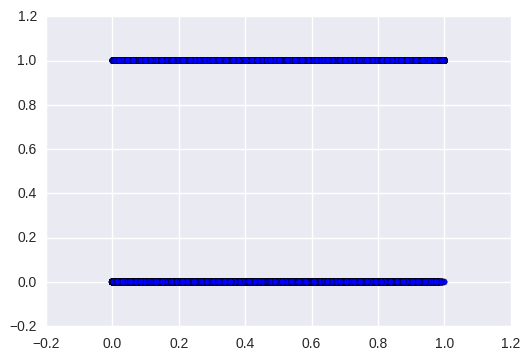

In [10]:
plt.scatter([i[1] for i in probs],y_test)

In [133]:
probs

array([[  1.27046734e-01,   8.72953266e-01],
       [  9.99043157e-01,   9.56843178e-04],
       [  1.69610446e-01,   8.30389554e-01],
       ..., 
       [  7.83868640e-01,   2.16131360e-01],
       [  7.66786985e-02,   9.23321302e-01],
       [  9.14099859e-01,   8.59001410e-02]])

In [112]:
inv_dict = inv_map = {v: k for k, v in tok.vocabulary_.iteritems()}
inv_dict

{0: u'000',
 1: u'10',
 2: u'100',
 3: u'1000',
 4: u'10th',
 5: u'11',
 6: u'12',
 7: u'12th',
 8: u'13',
 9: u'14',
 10: u'15',
 11: u'15000',
 12: u'16',
 13: u'17',
 14: u'18',
 15: u'19',
 16: u'1st',
 17: u'20',
 18: u'200',
 19: u'2000',
 20: u'2013',
 21: u'2014',
 22: u'2015',
 23: u'2016',
 24: u'2017',
 25: u'21',
 26: u'22',
 27: u'24',
 28: u'25',
 29: u'2nd',
 30: u'30',
 31: u'3d',
 32: u'3g',
 33: u'40',
 34: u'4g',
 35: u'50',
 36: u'500',
 37: u'60',
 38: u'6s',
 39: u'ability',
 40: u'able',
 41: u'about',
 42: u'above',
 43: u'abroad',
 44: u'ac',
 45: u'academic',
 46: u'accept',
 47: u'accepted',
 48: u'access',
 49: u'according',
 50: u'account',
 51: u'accounts',
 52: u'accurate',
 53: u'achieve',
 54: u'acid',
 55: u'acne',
 56: u'across',
 57: u'act',
 58: u'action',
 59: u'active',
 60: u'activities',
 61: u'activity',
 62: u'actor',
 63: u'actors',
 64: u'actress',
 65: u'actual',
 66: u'actually',
 67: u'ad',
 68: u'add',
 69: u'added',
 70: u'addiction',
 

In [48]:
train_df.loc[0][['question1','question2']]

question1    What is the step by step guide to invest in sh...
question2    What is the step by step guide to invest in sh...
Name: 0, dtype: object

In [49]:
tf_idf_1[0].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [92]:
train_df['question1'].iloc[0]

u'What is the step by step guide to invest in share market in india?'

In [105]:
g=tok.transform([u'What is the step by step guide to invest in share market in india?']).toarray()[0]